In [1]:
from __future__ import print_function
import keras
import os
import json
import matplotlib.pyplot as plt
import datetime
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from time import time
from keras.callbacks import TensorBoard


from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

In [3]:
# Create logfile.
logfile = open("logs/Cifar10_CNN.log", "a")
def log_entry(s):
    #print('Date now: %s' % datetime.datetime.now())

    timestamp = '[%s] : ' % datetime.datetime.now()
    log_line = timestamp + s + '\n'
    logfile.write(log_line)
    logfile.flush()

In [4]:
def parseFloat(x):
    try:
        x = float(x)
    except:
        x = 0
        log_entry("Unable to conveert ot float")
    return x

def convertToInt(x):
    try:
        x = int(x)
    except:
        x = 0
        log_entry("Unable to conveert ot int")
    return x

In [5]:
class Histories(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.aucs = []
        self.losses = []
    def on_train_end(self, logs={}):
        return
    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        y_pred = self.model.predict(self.model.validation_data[0])
        self.aucs.append(roc_auc_score(self.model.validation_data[1], y_pred))
        return
    def on_batch_begin(self, batch, logs={}):
        return
    def on_batch_end(self, batch, logs={}):
        return

In [6]:
#Start program by loading json file
#log_entry("Reading json file")

#read parameters from config file
with open('config/config.json') as json_file:    
        json_data = json.load(json_file)

log_entry("Json file loaded")

In [7]:
batch_size = convertToInt(json_data["batch_size"])
num_classes = convertToInt(json_data["num_classes"])
epochs = convertToInt(json_data["epochs"])
data_augmentation = json_data["data_augmentation"]
num_predictions = convertToInt(json_data["num_predictions"])
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [8]:
# The data, shuffled and split between train and test sets:
log_entry("Loading dataset")
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [9]:
# Convert class vectors to binary class matrices.
log_entry("Convert class vectors to binary class matrices")
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [11]:
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [12]:
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [13]:
# initiate RMSprop optimizer
log_entry("# initiate RMSprop optimizer")
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

In [14]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [15]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [16]:
log_entry("start training model")
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    tensorboard = TensorBoard(log_dir="logs/{}".format(time()),histogram_freq=0,write_graph=True, write_images=True)
    
    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4, callbacks=[tensorboard])

Using real-time data augmentation.
Epoch 1/100
1563/1563 [==============================] - 26s 16ms/step - loss: 1.8411 - acc: 0.3243 - val_loss: 1.5920 - val_acc: 0.4183
Epoch 2/100
1563/1563 [==============================] - 24s 15ms/step - loss: 1.5735 - acc: 0.4260 - val_loss: 1.4214 - val_acc: 0.4855
Epoch 3/100
1563/1563 [==============================] - 22s 14ms/step - loss: 1.4475 - acc: 0.4764 - val_loss: 1.3024 - val_acc: 0.5355
Epoch 4/100
1563/1563 [==============================] - 25s 16ms/step - loss: 1.3550 - acc: 0.5142 - val_loss: 1.1641 - val_acc: 0.5875
Epoch 5/100
1563/1563 [==============================] - 25s 16ms/step - loss: 1.2791 - acc: 0.5430 - val_loss: 1.1073 - val_acc: 0.6109
Epoch 6/100
1563/1563 [==============================] - 25s 16ms/step - loss: 1.2043 - acc: 0.5718 - val_loss: 1.0303 - val_acc: 0.6397
Epoch 7/100
1563/1563 [==============================] - 25s 16ms/step - loss: 1.1541 - acc: 0.5910 - val_loss: 0.9962 - val_acc: 0.6503
Epoch 

1563/1563 [==============================] - 25s 16ms/step - loss: 0.7484 - acc: 0.7499 - val_loss: 0.6514 - val_acc: 0.7879
Epoch 65/100
1563/1563 [==============================] - 23s 15ms/step - loss: 0.7460 - acc: 0.7499 - val_loss: 0.6308 - val_acc: 0.7989
Epoch 66/100
1563/1563 [==============================] - 24s 16ms/step - loss: 0.7495 - acc: 0.7511 - val_loss: 0.6561 - val_acc: 0.7906
Epoch 67/100
1563/1563 [==============================] - 23s 15ms/step - loss: 0.7454 - acc: 0.7490 - val_loss: 0.6312 - val_acc: 0.7964
Epoch 68/100
1563/1563 [==============================] - 25s 16ms/step - loss: 0.7481 - acc: 0.7503 - val_loss: 0.6338 - val_acc: 0.7986
Epoch 69/100
1563/1563 [==============================] - 24s 15ms/step - loss: 0.7433 - acc: 0.7522 - val_loss: 0.6804 - val_acc: 0.7798
Epoch 70/100
 607/1563 [==========>...................] - ETA: 13s - loss: 0.7425 - acc: 0.7510

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1563/1563 [==============================] - 25s 16ms/step - loss: 0.7531 - acc: 0.7491 - val_loss: 0.7178 - val_acc: 0.7622
Epoch 75/100
1563/1563 [==============================] - 24s 16ms/step - loss: 0.7532 - acc: 0.7483 - val_loss: 0.6435 - val_acc: 0.7865
Epoch 76/100
1563/1563 [==============================] - 25s 16ms/step - loss: 0.7497 - acc: 0.7492 - val_loss: 0.6660 - val_acc: 0.7882
Epoch 77/100
1563/1563 [==============================] - 25s 16ms/step - loss: 0.7508 - acc: 0.7492 - val_loss: 0.7327 - val_acc: 0.7768
Epoch 78/100
1563/1563 [==============================] - 25s 16ms/step - loss: 0.7540 - acc: 0.7512 - val_loss: 0.6227 - val_acc: 0.7992
Epoch 79/100
1563/1563 [==============================] - 24s 16ms/step - loss: 0.7534 - acc: 0.7529 - val_loss: 0.6703 - val_acc: 0.7918
Epoch 80/100
1563/1563 [==============================] - 24s 15ms/step - loss: 0.7561 - acc: 0.7502 - val_loss: 0.6561 - val_acc: 0.7919
Epoch 81/100
1563/1563 [=======================

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

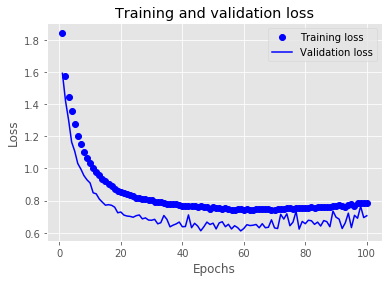

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

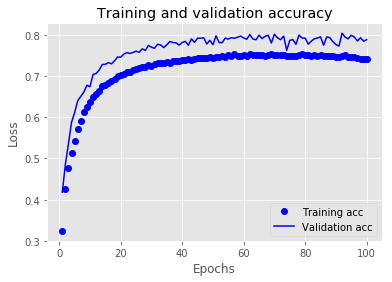

In [19]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /home/ubuntu/ssl/saved_models/keras_cifar10_trained_model.h5 


In [ ]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])